<a href="https://colab.research.google.com/github/jonzyyyy/AlphaLab/blob/main/AlphaLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup & Libraries

### Setting up necessary keys and env variables
(only required to run at the start of execution)

In [1]:
!pip install python-dotenv --quiet

from google.colab import drive
drive.mount('/content/drive')

# Copy Alpha Lab notebook to folder
!cp "/content/drive/MyDrive/Colab Notebooks/AlphaLab.ipynb" AlphaLab/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create regular file 'AlphaLab/': Not a directory


In [2]:
!pip install yfinance --quiet
!pip install vectorbt --quiet
!pip install streamlit pyngrok --quiet

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import vectorbt as vbt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pyngrok import ngrok
import os

This block of code below expects a secret that contains the necessary private API keys.

API Keys required:
1. NGROK

In [4]:
# !ngrok config add-authtoken NGROK_API_KEY
from google.colab import userdata
ngrok_token = userdata.get('NGROK_API_KEY')
ngrok.set_auth_token(ngrok_token)

In [5]:
# Parameters
SPLIT_RATIO = 0.7
DATA_YEARS = 2
TOP_N_STOCKS = 5


# --- Caching Configuration for S&P500 Data ---
DEBUG = True # Set to True to use cached data, False to fetch live data.
CACHE_FILE = 'sp500_market_caps.csv'

# 2. Download S&P 500 Stocks List
For simplicity, we'll fetch the tickers from Wikipedia

In [6]:
# --- Caching Logic ---
if DEBUG and os.path.exists(CACHE_FILE):
    print(f"DEBUG mode is ON. Loading data from cache file: {CACHE_FILE}")
    market_caps_df = pd.read_csv(CACHE_FILE)
else:
    print(f"Fetching live data. DEBUG is OFF or cache file not found.")
    # Get S&P 500 tickers from Wikipedia
    sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    sp500_table = pd.read_html(sp500_url)
    sp500 = sp500_table[0]
    # Correctly handle potential discrepancies in ticker symbols (e.g., 'BRK.B' vs 'BRK-B')
    tickers = sp500['Symbol'].str.replace('.', '-', regex=False).tolist()

    # We'll store market caps in a list of tuples
    market_caps = []

    print("Downloading market cap data for S&P 500 tickers...")
    for ticker in tickers:
        try:
            info = yf.Ticker(ticker).info
            cap = info.get('marketCap', None)
            if cap is not None:
                market_caps.append((ticker, cap))
        except Exception as e:
            # print(f"Could not fetch data for {ticker}: {e}")
            continue  # skip tickers with issues

    # Convert to DataFrame
    market_caps_df = pd.DataFrame(market_caps, columns=['Ticker', 'MarketCap'])

    # Sort by market cap, descending
    market_caps_df = market_caps_df.sort_values(by='MarketCap', ascending=False).reset_index(drop=True)

    # Save the fetched data to the cache file for future use
    market_caps_df.to_csv(CACHE_FILE, index=False)
    print(f"Live data saved to cache file: {CACHE_FILE}")

# --- Display the result ---
print("\nTop 5 S&P 500 companies by market cap:")
print(market_caps_df.head())

DEBUG mode is ON. Loading data from cache file: sp500_market_caps.csv

Top 5 S&P 500 companies by market cap:
  Ticker      MarketCap
0   NVDA  4146372542464
1   MSFT  3746223095808
2   AAPL  3158324281344
3   AMZN  2390707142656
4  GOOGL  2234568933376


In [7]:
print(market_caps_df.head(5))  # Show top 5 largest S&P 500 stocks
# (Optional) Use a smaller subset for a fast demo
tickers = market_caps_df['Ticker'][:25].tolist()  # Change to 50 or 100 if you want more
print(tickers)

  Ticker      MarketCap
0   NVDA  4146372542464
1   MSFT  3746223095808
2   AAPL  3158324281344
3   AMZN  2390707142656
4  GOOGL  2234568933376
['NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOGL', 'GOOG', 'META', 'AVGO', 'TSLA', 'BRK-B', 'JPM', 'WMT', 'LLY', 'V', 'ORCL', 'NFLX', 'MA', 'XOM', 'COST', 'JNJ', 'PG', 'HD', 'PLTR', 'BAC', 'ABBV']


In [8]:
# =======================
# 3. Download Price Data
# =======================
end = datetime.today()
start = end - timedelta(days=365*DATA_YEARS)  # Last 2 years
price_data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, progress=False)
# print(price_data.head(3))

In [9]:
# =======================
# 4. Train-Test Split
# =======================
all_dates = price_data[tickers[0]]['Close'].index
split_idx = int(len(all_dates) * SPLIT_RATIO)
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]

# Helper function to get price for a given ticker and period
def get_close_prices(ticker, dates):
    try:
        close = price_data[ticker]['Close'].reindex(dates)
        return close
    except:
        return pd.Series(index=dates, dtype=float)

# Factor Based Algorithmic Equity Strategy

## Factor Used
1. Trailing P/E ratio - measures a company's current share price against its actual, historical earnings from the previous 12 months

    **Formula**: `Current Share Price / Trailing 12-Month EPS`

    **Limitation**: Past performance is not a guarantee of future results

2.

## To consider
1. Forward P/E ratio - forward-looking metric that measures a company's current share price relative to its estimated future earnings per share (EPS)

    **Formula**: `Current Share Price / Forecasted 12-Month EPS`

    **Limitation**: Its primary weakness is that it's based on estimates, which can be inaccurate, overly optimistic, or change frequently.



In [10]:
# =======================
# 5. Factor Calculation (Value, Momentum)
# =======================
factor_df = pd.DataFrame(index=tickers)

# Value factor: Trailing P/E (lower is "better")
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        factor_df.loc[ticker, 'pe_ratio'] = info.get('trailingPE', np.nan)
    except Exception:
        factor_df.loc[ticker, 'pe_ratio'] = np.nan

# Momentum factor: 6-month price return
for ticker in tickers:
    try:
        prices = price_data[ticker]['Close'].dropna()
        if len(prices) > 126:
            factor_df.loc[ticker, '6m_return'] = (prices.iloc[-1] / prices.iloc[-126]) - 1
        else:
            factor_df.loc[ticker, '6m_return'] = np.nan
    except Exception:
        factor_df.loc[ticker, '6m_return'] = np.nan

# Drop rows with missing factors
factor_df = factor_df.dropna()
# print(factor_df.head(20))

In [11]:
# =======================
# 6. Composite Scoring & Stock Selection
# =======================
# Rank: lower P/E is better, higher momentum is better
factor_df['pe_rank'] = factor_df['pe_ratio'].rank(ascending=True)
factor_df['mom_rank'] = factor_df['6m_return'].rank(ascending=False)
# Simple equal-weight composite score
factor_df['composite_score'] = (factor_df['pe_rank'] + factor_df['mom_rank']) / 2

# Select top N stocks
selected = factor_df.nsmallest(TOP_N_STOCKS, 'composite_score')
selected_tickers = selected.index.tolist()
print("Selected stocks for backtest:", selected_tickers)

Selected stocks for backtest: ['JPM', 'JNJ', 'META', 'BRK-B', 'ORCL']


In [12]:
# =======================
# 7. Backtesting (Quarterly Rebalancing)
# =======================

# Filter price data for selected tickers and train/test periods
selected_prices_train = price_data[selected_tickers].reindex(train_dates)
selected_prices_test = price_data[selected_tickers].reindex(test_dates)

# 1. Find all trading days in your price data
all_dates = selected_prices_test.index

# 2. Set target rebalance dates (e.g., quarterly)
rebalance_targets = pd.date_range(start=all_dates[0], end=all_dates[-1], freq='QS')

# 3. Map each target rebalance date to the nearest available trading day ON OR AFTER the target
mapped_rebalance_dates = []
for target in rebalance_targets:
    candidates = all_dates[all_dates >= target]
    if not candidates.empty:
        mapped_rebalance_dates.append(candidates[0])
# Always include the very first day if it's not already in the list
if all_dates[0] not in mapped_rebalance_dates:
    mapped_rebalance_dates = [all_dates[0]] + mapped_rebalance_dates

print("Final mapped rebalance dates:", mapped_rebalance_dates)

# 4. Assign weights on these mapped rebalance dates
portfolio = pd.DataFrame(1 / len(selected_prices_test.columns), index=all_dates, columns=selected_prices_test.columns)
# print(portfolio.head(20))

# 5. Returns and cumulative returns
returns = selected_prices_test.pct_change().fillna(0)

# Recalculate portfolio returns by applying weights only to 'Close' returns
# Select only the 'Close' returns for the selected tickers
close_returns_only = returns.loc[:, (selected_tickers, 'Close')]

# Select only the 'Close' weights for the selected tickers
portfolio_close_weights = portfolio.loc[:, (selected_tickers, 'Close')]

# Calculate portfolio returns by multiplying close returns with close weights and summing across tickers
portfolio_returns_corrected = (close_returns_only * portfolio_close_weights).sum(axis=1)

# Update the cum_returns as well since the original portfolio_returns was incorrect
cum_returns_corrected = (1 + portfolio_returns_corrected).cumprod()

# Rename the corrected variables to match the original variable names for consistency in subsequent cells
portfolio_returns = portfolio_returns_corrected
cum_returns = cum_returns_corrected

print(portfolio_returns.head())

Final mapped rebalance dates: [Timestamp('2024-12-05 00:00:00'), Timestamp('2025-01-02 00:00:00'), Timestamp('2025-04-01 00:00:00'), Timestamp('2025-07-01 00:00:00')]
Date
2024-12-05    0.000000
2024-12-06    0.002390
2024-12-09   -0.001973
2024-12-10   -0.002668
2024-12-11    0.000373
dtype: float64


<Figure size 1200x600 with 0 Axes>

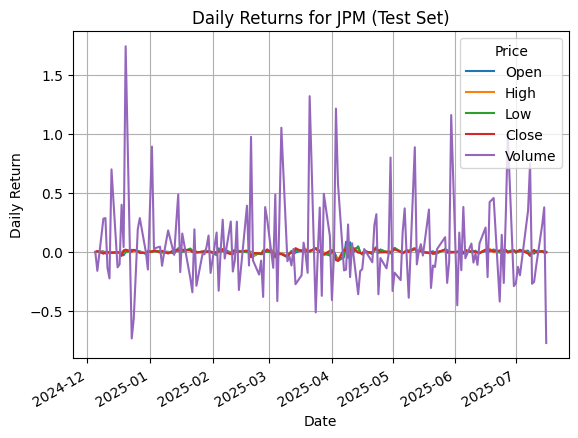

<Figure size 1200x600 with 0 Axes>

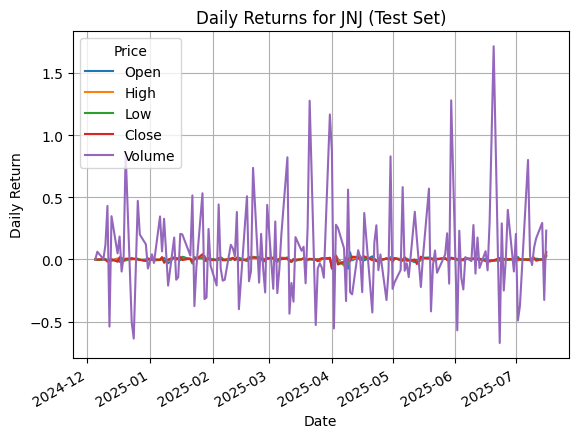

<Figure size 1200x600 with 0 Axes>

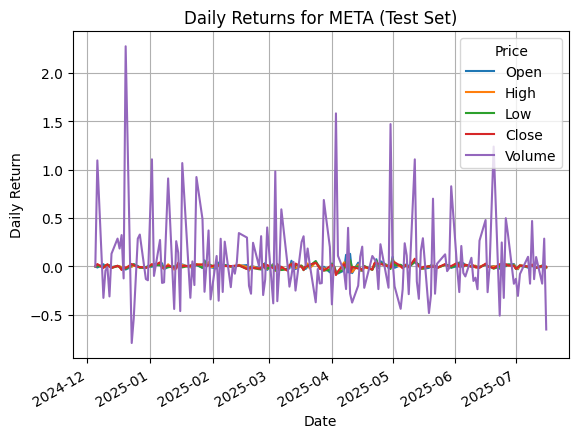

<Figure size 1200x600 with 0 Axes>

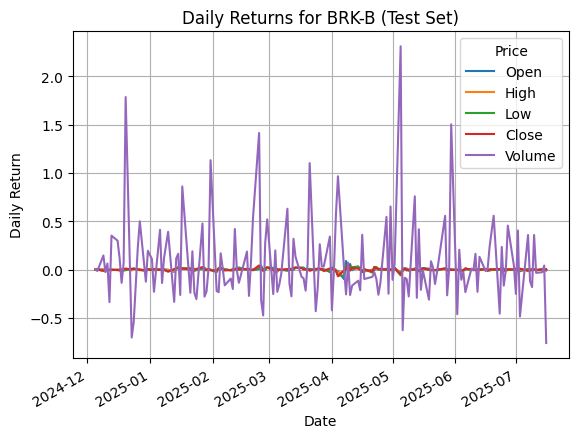

<Figure size 1200x600 with 0 Axes>

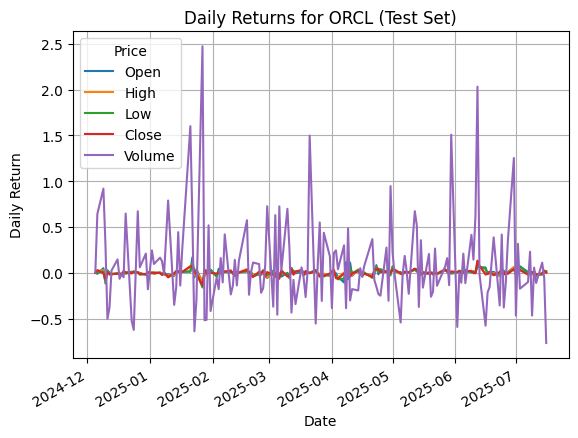

In [13]:
# =======================
# 8a. Results Visualization
# =======================
# Plot daily returns for each selected stock
for ticker in selected_tickers:
    plt.figure(figsize=(12, 6))
    returns[ticker].plot()
    plt.title(f'Daily Returns for {ticker} (Test Set)')
    plt.ylabel('Daily Return')
    plt.xlabel('Date')
    plt.grid()
    plt.show()

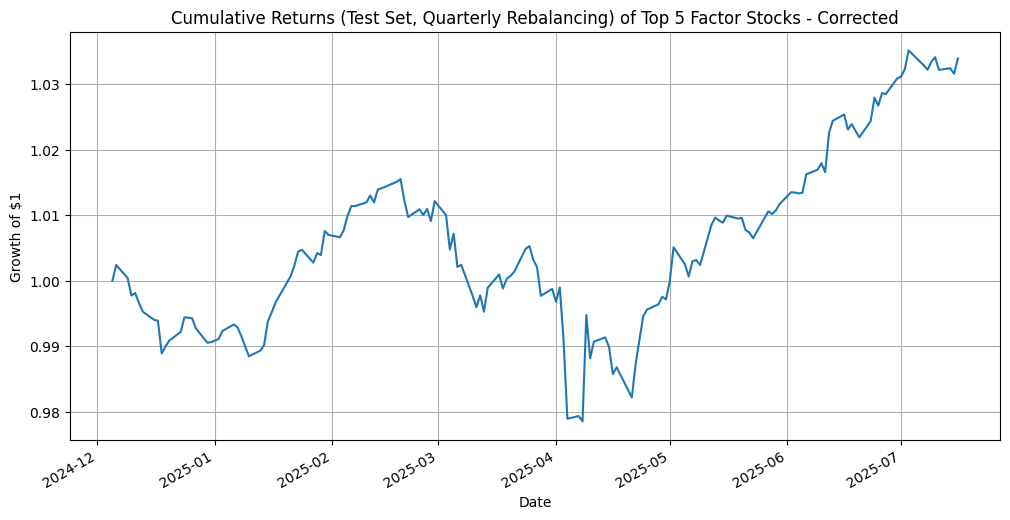

In [14]:
# =======================
# 8b. cum_returns Results Visualization
# =======================
plt.figure(figsize=(12,6))
cum_returns.plot() # Use the corrected cum_returns
plt.title('Cumulative Returns (Test Set, Quarterly Rebalancing) of Top 5 Factor Stocks - Corrected') # Update title
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.grid()
plt.show()

In [15]:
# =======================
# 9. Simple Performance Stats
# =======================
total_return = cum_returns.iloc[-1] - 1
annualized_return = cum_returns.iloc[-1]**(252/len(cum_returns)) - 1
annualized_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = annualized_return / annualized_vol

print(f"Last value of cumulative returns: {cum_returns.iloc[-1]:.2f}")
print(f"Total Return (Test): {total_return:.2%}")
print(f"Annualized Return (Test): {annualized_return:.2%}")
print(f"Annualized Volatility (Test): {annualized_vol:.2%}")
print(f"Sharpe Ratio (Test): {sharpe:.2f}")

Last value of cumulative returns: 1.03
Total Return (Test): 3.40%
Annualized Return (Test): 5.73%
Annualized Volatility (Test): 4.53%
Sharpe Ratio (Test): 1.27


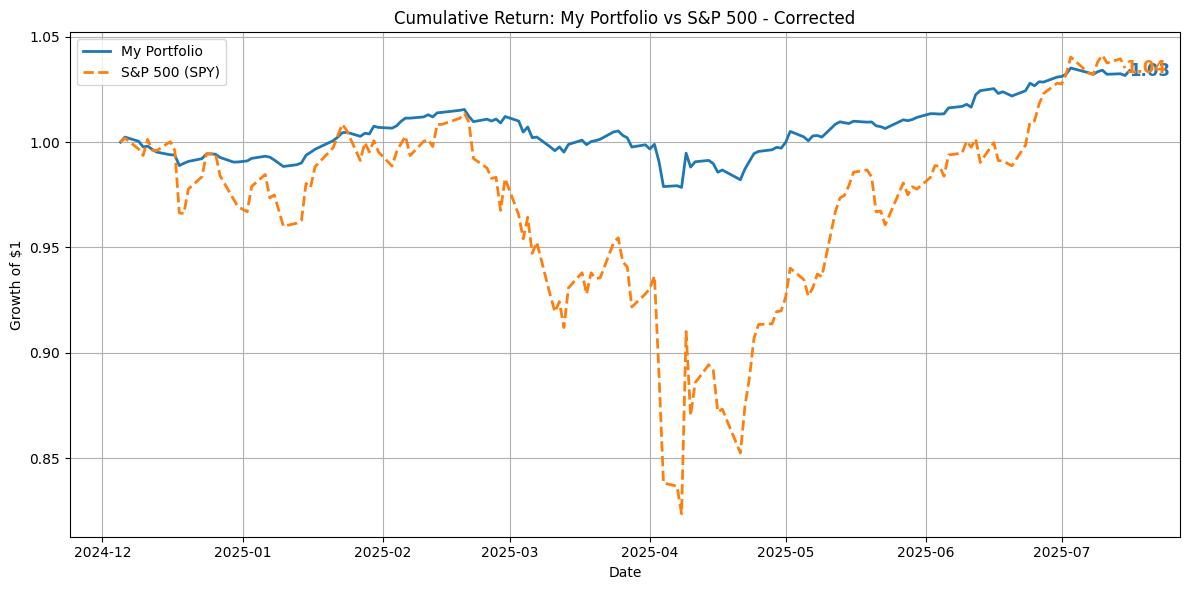

In [16]:
# =======================
# 8. Results Visualization (with Benchmark)
# =======================

# 1. Download S&P 500 (SPY) data for the test period
spy_ticker = 'SPY' # or 'SPY' for the ETF
spy_data = yf.download(spy_ticker, start=test_dates[0], end=test_dates[-1], auto_adjust=True, progress=False)
spy_close_prices = spy_data['Close']

# 2. Calculate SPY's daily returns and cumulative returns
benchmark_returns = spy_close_prices.pct_change().fillna(0)
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Align the two time series to a common index
common_index = cum_returns.index.union(benchmark_cum_returns.index)
cum_returns_aligned = cum_returns.reindex(common_index)
benchmark_cum_returns_aligned = benchmark_cum_returns.reindex(common_index)


# 3. Plot both on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot your portfolio
plt.plot(cum_returns_aligned.index, cum_returns_aligned.values,
         label='My Portfolio', linewidth=2)

# Plot the benchmark
plt.plot(benchmark_cum_returns_aligned.index, benchmark_cum_returns_aligned.values,
         linestyle='--', label='S&P 500 (SPY)', linewidth=2)

# Annotate final values
last_portfolio_date = cum_returns_aligned.dropna().index[-1]
last_portfolio_value = cum_returns_aligned.dropna().iloc[-1]

last_benchmark_date = benchmark_cum_returns_aligned.dropna().index[-1]
last_benchmark_value = benchmark_cum_returns_aligned.dropna().iloc[-1].iloc[0] # Access the scalar value


plt.text(last_portfolio_date, last_portfolio_value,
         f"{last_portfolio_value:.2f}",
         color='C0', fontsize=12, va='center', ha='left', fontweight='bold')

plt.text(last_benchmark_date, last_benchmark_value,
         f"{last_benchmark_value:.2f}",
         color='C1', fontsize=12, va='center', ha='left', fontweight='bold')

plt.title('Cumulative Return: My Portfolio vs S&P 500 - Corrected') # Update title
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Saves entire file to app.py

In [17]:
%%writefile app.py
# This entire cell will be saved as app.py


import streamlit as st
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
import time # Import time for simulating progress
import os # Import os for checking file existence

# Define functions (copied from the Colab notebook)

def download_sp500_tickers(debug=False, storage_path='sp500_tickers.parquet'):
    """
    Fetches S&P 500 tickers and market caps and returns a sorted DataFrame.
    If debug is True, attempts to load from storage_path first.
    If loading fails or debug is False, downloads from Wikipedia and saves to storage_path.
    """
    if debug and os.path.exists(storage_path):
        try:
            st.info(f"Attempting to load S&P 500 tickers from {storage_path}...")
            market_caps_df = pd.read_parquet(storage_path)
            st.success(f"Successfully loaded S&P 500 tickers from {storage_path}.")
            return market_caps_df
        except Exception as e:
            st.warning(f"Could not load S%26P 500 tickers from {storage_path}: {e}. Downloading instead.")

    # If not in debug mode or loading failed, download from Wikipedia
    try:
        sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        sp500_table = pd.read_html(sp500_url)
        sp500 = sp500_table[0]
        tickers = sp500['Symbol'].tolist()
        market_caps = []
        total_tickers = len(tickers)
        progress_bar = st.progress(0)
        status_text = st.empty()

        st.info("Downloading S&P 500 data from Wikipedia...")
        for i, ticker in enumerate(tickers):
            try:
                info = yf.Ticker(ticker).info
                cap = info.get('marketCap', None)
                if cap is not None:
                    market_caps.append((ticker, cap))
            except Exception:
                continue
            # Update progress bar and status text
            progress = (i + 1) / total_tickers
            progress_bar.progress(progress)
            status_text.text(f"Downloading S&P 500 data: {i+1}/{total_tickers} tickers processed...")

        progress_bar.empty()
        status_text.empty()

        market_caps_df = pd.DataFrame(market_caps, columns=['Ticker', 'MarketCap'])
        market_caps_df = market_caps_df.sort_values(by='MarketCap', ascending=False).reset_index(drop=True)

        # Save the downloaded data to Parquet
        try:
            market_caps_df.to_parquet(storage_path)
            st.success(f"Saved S&P 500 tickers to {storage_path}.")
        except Exception as e:
            st.warning(f"Could not save S%26P 500 tickers to {storage_path}: {e}")

        return market_caps_df
    except Exception as e:
        st.error(f"Error downloading S%26P 500 tickers from Wikipedia: {e}")
        return pd.DataFrame(columns=['Ticker', 'MarketCap'])


def download_price_data(tickers, start_date, end_date):
    """Downloads historical price data for a list of tickers."""
    try:
        st.info(f"Downloading price data for {len(tickers)} tickers...")
        price_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True, progress=False)
        # yf.download returns a DataFrame with a MultiIndex on columns if multiple tickers are downloaded.
        # The levels are ('Ticker', 'Price_Info').
        # If only one ticker is downloaded, it returns a DataFrame with a single level index ('Price_Info').
        st.success("Price data downloaded.")
        return price_data
    except Exception as e:
        st.error(f"Error downloading price data: {e}")
        return pd.DataFrame()


def calculate_factors(price_data_close, tickers):
    """Calculates Value (P/E) and Momentum (6-month return) factors."""
    st.info("Calculating factors...")
    factor_df = pd.DataFrame(index=tickers)
    total_tickers = len(tickers)
    progress_bar = st.progress(0)
    status_text = st.empty()

    # st.text(f"Calculating factors for {total_tickers} tickers...") # Added logging
    # st.text("Initial factor_df columns: pe_ratio, 6m_return") # Added logging


    for i, ticker in enumerate(tickers):
        try:
            info = yf.Ticker(ticker).info
            # Explicitly check if 'trailingPE' is None and assign np.nan if it is
            pe_ratio = info.get('trailingPE')
            factor_df.loc[ticker, 'pe_ratio'] = pe_ratio if pe_ratio is not None else np.nan
        except Exception as e: # Added exception logging
            factor_df.loc[ticker, 'pe_ratio'] = np.nan
            # st.text(f"Error getting PE for {ticker}: {e}") # Added logging


        try:
            # Use the simplified price_data_close DataFrame (single-level columns: Ticker)
            if ticker in price_data_close.columns:
                # Explicitly filter out NaNs instead of using dropna()
                prices = price_data_close[ticker][~price_data_close[ticker].isna()]
                if len(prices) > 126:
                    factor_df.loc[ticker, '6m_return'] = (prices.iloc[-1] / prices.iloc[-126]) - 1
                else:
                    factor_df.loc[ticker, '6m_return'] = np.nan
                    # st.text(f"Insufficient data for 6m return for {ticker}: {len(prices)} data points") # Added logging
            else:
                factor_df.loc[ticker, '6m_return'] = np.nan
                # st.text(f"Ticker {ticker} not in price_data_close columns.") # Added logging


        except Exception as e: # Added exception logging
            factor_df.loc[ticker, '6m_return'] = np.nan
            # st.text(f"Error calculating 6m return for {ticker}: {e}") # Added logging


        # Update progress bar and status text
        progress = (i + 1) / total_tickers
        progress_bar.progress(progress)
        status_text.text(f"Calculating factors: {i+1}/{total_tickers} tickers processed...")


    progress_bar.empty()
    status_text.empty()

    # st.text("Factor calculation loop finished.") # Added logging
    # st.text(f"Factor_df before dropna():\n{factor_df}") # Added logging

    factor_df = factor_df.dropna() # Keep dropna here for rows with missing factors

    # st.text(f"Factor_df after dropna():\n{factor_df}") # Added logging


    if not factor_df.empty:
        factor_df['pe_rank'] = factor_df['pe_ratio'].rank(ascending=True)
        factor_df['mom_rank'] = factor_df['6m_return'].rank(ascending=False)
        factor_df['composite_score'] = (factor_df['pe_rank'] + factor_df['mom_rank']) / 2
        st.success(f"Factors calculated for {len(factor_df)} tickers.") # Updated success message
    else:
        st.warning("No tickers with complete factor data found.") # Added specific warning
    return factor_df

def select_top_n_stocks(factor_df, top_n):
    """Selects the top N stocks based on the composite score."""
    st.info(f"Selecting top {top_n} stocks...")
    if not factor_df.empty:
        selected = factor_df.nsmallest(top_n, 'composite_score')
        selected_tickers = selected.index.tolist()
        st.success(f"Selected stocks: {selected_tickers}")
        return selected_tickers
    st.warning("No stocks selected because factor_df is empty.") # Updated warning
    return []


def run_backtest(price_data_close, selected_tickers, split_ratio, rebalance_freq='QS'):
    """Runs a quarterly rebalancing backtest on selected stocks."""
    st.info("Running backtest...")
    if not selected_tickers or price_data_close.empty:
        st.warning("Backtest skipped due to missing data or selected tickers.")
        return pd.Series(), pd.Series()

    try:
        # Filter price data for selected tickers and test period (already close prices)
        all_dates = price_data_close.index
        split_idx = int(len(all_dates) * split_ratio)
        test_dates = all_dates[split_idx:]

        if test_dates.empty:
             st.warning("Test period is empty. Adjust split ratio or data years.")
             return pd.Series(index=all_dates), pd.Series(index=all_dates)


        # Ensure selected_tickers columns exist in price_data_close
        valid_selected_tickers = [t for t in selected_tickers if t in price_data_close.columns]

        if not valid_selected_tickers:
             st.warning("None of the selected tickers have price data available in the test period.")
             return pd.Series(index=test_dates), pd.Series(index=test_dates)

        selected_prices_test_close = price_data_close.loc[test_dates, valid_selected_tickers]


        all_test_dates = selected_prices_test_close.index
        rebalance_targets = pd.date_range(start=all_test_dates[0], end=all_test_dates[-1], freq=rebalance_freq)

        mapped_rebalance_dates = []
        for target in rebalance_targets:
            candidates = all_test_dates[all_test_dates >= target]
            if not candidates.empty:
                mapped_rebalance_dates.append(candidates[0])
        if all_test_dates[0] not in mapped_rebalance_dates:
            mapped_rebalance_dates = [all_test_dates[0]] + mapped_rebalance_dates

        # Initialize portfolio weights equally
        # Ensure weights DataFrame has the same columns as selected_prices_test_close
        portfolio = pd.DataFrame(1 / len(valid_selected_tickers), index=all_test_dates, columns=valid_selected_tickers)


        # Calculate daily returns using the close prices only
        returns = selected_prices_test_close.pct_change().fillna(0)

        # Calculate portfolio returns by applying weights to daily returns and summing across tickers
        # Multiplication should now work as both DataFrames have the same single-level columns (Tickers)
        portfolio_returns = (returns * portfolio).sum(axis=1)

        # Calculate cumulative returns
        cum_returns = (1 + portfolio_returns).cumprod()

        st.success("Backtest completed.")
        return cum_returns, portfolio_returns
    except Exception as e:
        st.error(f"Error during backtest: {e}")
        # Return empty series with the correct index if possible to avoid downstream errors
        if 'test_dates' in locals():
             return pd.Series(index=test_dates), pd.Series(index=test_dates)
        else:
             return pd.Series(), pd.Series()


# Set the title of the Streamlit application
st.title('Stock Backtesting Strategy')

# Create a section for parameter inputs
st.header('Backtesting Parameters')
with st.expander("Adjust Parameters"):
    st.write("Configure the parameters for the backtesting simulation.")

    # Add DEBUG checkbox
    debug_mode = st.checkbox('Debug Mode (Load S&P 500 tickers from storage)')


    # Input widget for SPLIT_RATIO
    split_ratio = st.number_input(
        'Train/Test Split Ratio',
        min_value=0.1,
        max_value=0.9,
        value=0.7,
        step=0.05,
        help="Ratio of data to use for training (e.g., 0.7 for 70% train, 30% test)"
    )

    # Input widget for DATA_YEARS
    data_years = st.number_input(
        'Number of Years of Data',
        min_value=1,
        max_value=10,
        value=2,
        step=1,
        help="Number of years of historical data to download"
    )

    # Input widget for TOP_N_STOCKS
    top_n_stocks = st.number_input(
        'Top N Stocks to Select',
        min_value=1,
        max_value=50,
        value=5,
        step=1,
        help="Number of top-ranked stocks to include in the portfolio"
    )

# Define the main logic to run when parameters change
if st.button('Run Backtest'):
    # Get the current date
    end_date = datetime.today()
    # Calculate the start date based on DATA_YEARS
    start_date = end_date - timedelta(days=365 * data_years)

    # --- Backtesting Logic ---
    # Download S&P 500 tickers (using a subset for faster demo)
    with st.spinner("Downloading S&P 500 tickers..."):
        # Pass the debug_mode value to the function
        market_caps_df = download_sp500_tickers(debug=debug_mode)
    if market_caps_df.empty:
        st.stop()

    all_tickers = market_caps_df['Ticker'].tolist()
    # Use a smaller subset for faster demo
    subset_tickers = all_tickers[:50] # Adjust subset size as needed

    # Download price data for the subset
    price_data = download_price_data(subset_tickers, start_date, end_date)
    if price_data.empty:
        st.stop()

    # Explicitly extract only 'Close' prices and create a new DataFrame with simple columns
    if isinstance(price_data.columns, pd.MultiIndex):
         # Select 'Close' for all tickers in subset_tickers
         price_data_close = price_data.loc[:, (subset_tickers, 'Close')]
         # Drop the 'Price' level to have tickers as single-level columns
         price_data_close.columns = price_data_close.columns.droplevel('Price')
    else: # Handle case where price_data might not have a MultiIndex (e.g., single ticker download)
         # Assuming it's already the close series for a single ticker, convert to DataFrame
         price_data_close = pd.DataFrame(price_data)
         price_data_close.columns = [subset_tickers[0]] # Set the ticker as the column name


    # Calculate factors and select top N stocks using the simplified price_data_close
    factor_df = calculate_factors(price_data_close, subset_tickers)
    if factor_df.empty:
        st.warning("Could not calculate factors for any tickers. Please adjust parameters (e.g., increase data years or reduce the number of top stocks).") # More informative warning
        st.stop()

    selected_tickers = select_top_n_stocks(factor_df, top_n_stocks)

    if not selected_tickers:
        st.warning("No stocks selected based on the criteria after factor calculation. Please adjust parameters.")
    else:
        # st.write(f"Selected stocks for backtest: {selected_tickers}") # Moved inside select_top_n_stocks

        # Run the backtest using the simplified price_data_close
        cum_returns, portfolio_returns = run_backtest(price_data_close, selected_tickers, split_ratio)

        if cum_returns.empty:
             st.warning("Backtest did not produce cumulative returns. Check data availability and parameters.")
             st.stop()


        # Download SPY data for benchmark
        spy_ticker = '^GSPC'
        try:
            with st.spinner("Downloading benchmark data..."):
                # Download benchmark data for the specific test period
                # Ensure benchmark data aligns with the portfolio's test period index
                benchmark_data = yf.download(spy_ticker, start=cum_returns.index[0], end=cum_returns.index[-1], auto_adjust=True, progress=False)
            benchmark_cum_returns = (1 + benchmark_data['Close'].pct_change().fillna(0)).cumprod()
            benchmark_returns = benchmark_data['Close'].pct_change().fillna(0)


             # Align the two time series to a common index, forward filling missing values
            common_index = cum_returns.index.union(benchmark_cum_returns.index)
            cum_returns_aligned = cum_returns.reindex(common_index).fillna(method='ffill')
            benchmark_cum_returns_aligned = benchmark_cum_returns.reindex(common_index).fillna(method='ffill')

        except Exception as e:
             st.warning(f"Could not download benchmark data or align: {e}. Skipping benchmark.")
             cum_returns_aligned = cum_returns.reindex(cum_returns.index) # Ensure it's a Series even if benchmark fails
             benchmark_cum_returns_aligned = pd.Series(index=cum_returns.index) # Empty benchmark series with portfolio index
             benchmark_returns = pd.Series(index=cum_returns.index) # Initialize benchmark_returns to empty Series in case of error


        # --- Results Visualization (Interactive Graph) ---
        st.header('Cumulative Returns')
        st.write("Visualize the cumulative returns of the selected portfolio vs. a benchmark.")

        if not cum_returns_aligned.empty:
            # Create a DataFrame for plotting
            plot_df = pd.DataFrame({
                'Date': cum_returns_aligned.index,
                'My Portfolio': cum_returns_aligned.values
            })

            if not benchmark_cum_returns_aligned.empty:
                 # Only add benchmark if it's not an empty series
                 plot_df['S&P 500'] = benchmark_cum_returns_aligned.values

            # Reshape the DataFrame for Plotly
            plot_df_melted = plot_df.melt(
                'Date',
                var_name='Strategy',
                value_name='Cumulative Returns'
            )

            # Create the interactive Plotly line chart
            fig = px.line(
                plot_df_melted,
                x='Date',
                y='Cumulative Returns',
                color='Strategy',
                title='Cumulative Return: My Portfolio vs S&P 500'
            )

            # Display the Plotly figure in Streamlit
            st.plotly_chart(fig, use_container_width=True)
        else:
            st.warning("No cumulative returns data to plot.")

        # --- Performance Metrics ---
        st.header('Performance Metrics')
        st.write("Key performance indicators for the backtested strategy.")

        # Ensure we have enough data to calculate metrics
        if not portfolio_returns.empty and len(cum_returns) > 1:
            # --- Create Columns for Display ---
            col1, col2 = st.columns(2)

            # --- Portfolio Calculations ---
            with col1:
                st.subheader("My Portfolio")
                try:
                    total_return = cum_returns.iloc[-1] - 1
                    duration_years = len(cum_returns) / 252.0
                    annualized_return = (1 + total_return)**(1/duration_years) - 1
                    annualized_vol = portfolio_returns.std() * np.sqrt(252)

                    # Safely calculate Sharpe Ratio
                    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0.0

                    st.metric(label="Total Return", value=f"{total_return:.2%}")
                    st.metric(label="Annualized Return", value=f"{annualized_return:.2%}")
                    st.metric(label="Annualized Volatility", value=f"{annualized_vol:.2%}")
                    st.metric(label="Sharpe Ratio", value=f"{sharpe_ratio:.2f}")
                except Exception as e:
                    st.error(f"Error calculating portfolio metrics: {e}")


            # --- Benchmark Calculations ---
            with col2:
                st.subheader("S&P 500 (Benchmark)")
                # Check if benchmark data is valid before trying to calculate
                if not benchmark_returns.empty and not benchmark_returns.isnull().values.all() and len(benchmark_cum_returns) > 1:
                    try:
                        # Use .item() to ensure we have a single Python number
                        bench_total_return = (benchmark_cum_returns.iloc[-1] - 1).item()
                        bench_duration_years = len(benchmark_cum_returns) / 252.0
                        bench_annualized_return = (1 + bench_total_return)**(1/bench_duration_years) - 1
                        bench_annualized_vol = (benchmark_returns.std() * np.sqrt(252)).item()

                        # Safely calculate Sharpe Ratio for the benchmark
                        bench_sharpe_ratio = bench_annualized_return / bench_annualized_vol if bench_annualized_vol > 0 else 0.0

                        st.metric(label="Total Return", value=f"{bench_total_return:.2%}")
                        st.metric(label="Annualized Return", value=f"{bench_annualized_return:.2%}")
                        st.metric(label="Annualized Volatility", value=f"{bench_annualized_vol:.2%}")
                        st.metric(label="Sharpe Ratio", value=f"{bench_sharpe_ratio:.2f}")
                    except Exception as e:
                        st.error(f"Error calculating benchmark metrics: {e}")
                else:
                    st.warning("Not enough benchmark data to calculate metrics.")
        else:
            st.warning("No performance metrics to display. Insufficient data.")

Overwriting app.py


## Run streamlit app

### Subtask:
Start the Streamlit application using `streamlit run app.py`.


**Reasoning**:
The Streamlit application code has been written to `app.py`. The next step is to start the Streamlit server to run the application.



In [19]:
# This script will kill the old processes and start a new one.
from pyngrok import ngrok
from google.colab import userdata

# Step 1: Kill any running Streamlit process
# This is the crucial step you were missing.
print("Attempting to kill previous Streamlit process...")
!kill $(ps -ef | grep "streamlit" | grep -v "grep" | awk '{print $2}')
print("Kill command sent.")

# Step 2: Disconnect all ngrok tunnels and kill the ngrok process
print("\nDisconnecting all ngrok tunnels...")
ngrok.kill()

# Step 3: Relaunch everything
print("Setting up new ngrok tunnel...")
ngrok_token = userdata.get('NGROK_API_KEY')
if ngrok_token:
    ngrok.set_auth_token(ngrok_token)
else:
    print("WARNING: NGROK_API_KEY not found in Colab Secrets.")

# Open the tunnel
public_url = ngrok.connect(8501)
print(f"New Public URL: {public_url}")

# Run the updated app.py in the background
print("Starting new Streamlit app...")
!streamlit run app.py &>/dev/null&
print("App is running in the background. Please use the new public URL.")

Attempting to kill previous Streamlit process...
Kill command sent.

Disconnecting all ngrok tunnels...
Setting up new ngrok tunnel...
New Public URL: NgrokTunnel: "https://a5cace9ec4a2.ngrok-free.app" -> "http://localhost:8501"
Starting new Streamlit app...
App is running in the background. Please use the new public URL.
